# ARIMA 

Ensure stationarity, AR and MA parameter selection 

Parameters: 
- p : order of autoregression 
- d : integration, the grade of differencing 
- q : the order of moving average 

First needs to specify d. Once d is defined and the TS is stationary, we choose p and q. 


In [42]:
%load_ext autoreload
%autoreload 2

import sys, os 
from src.data import open_and_transform_csv2
from src.graphs import graph_df_strike_duration_selection
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 

# Add folder location to Python paths so that packages can be imported 
p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Strike = 100, Duration = 1Y


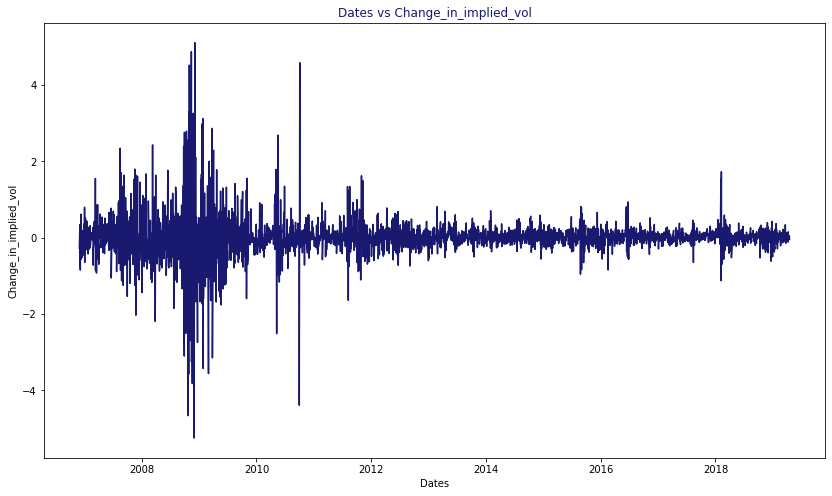

In [12]:
# Import data 
spx_daily = open_and_transform_csv2(r'../data/spx_daily.xlsx')
# Try only with one TS 
spx_daily_1Y_100 = spx_daily[(spx_daily.Strike == 100) & (spx_daily.Duration == "1Y")]
graph_df_strike_duration_selection(spx_daily, "1Y", 100, "Dates", "Change_in_implied_vol")

In [16]:
# First we need to transform the pd df to Series object with datetime index as tuples
spx_daily_1Y_100 = spx_daily_1Y_100.set_index("Dates")
spx_daily_1Y_100.sort_index(inplace=True)
spx_daily_1Y_100.head()

,Spot t,Spot t-1,Volatility,Duration,Strike,Implied_vol,Change_in_implied_vol
Dates,,,,,,,
2006-12-01,1396.71,1400.63,15.5451,1Y,100,15.470164,-0.275436
2006-12-04,1409.12,1396.71,15.6380,1Y,100,15.884285,0.339185
2006-12-05,1414.76,1409.12,14.7890,1Y,100,14.899351,-0.738649
2006-12-06,1412.90,1414.76,15.0645,1Y,100,15.030987,0.241987
2006-12-07,1407.29,1412.90,14.3064,1Y,100,14.216495,-0.848005


In [17]:
# Datetime pd series with tuple date index 
spots = pd.Series(spx_daily_1Y_100["Change_in_implied_vol"].values, \
                 index = pd.DatetimeIndex(tuple(pd.date_range(start = "2006-12-01", \
                                                              periods=spx_daily_1Y_100.shape[0], freq = "D")), freq="D"))

In [26]:
spots_train, spots_test = spots[:-10], spots[-10:]

In [30]:
spots_test

2015-09-25   -0.071540
2015-09-26    0.052775
2015-09-27    0.153400
2015-09-28   -0.114312
2015-09-29    0.029991
2015-09-30    0.022836
2015-10-01    0.053275
2015-10-02    0.006670
2015-10-03    0.037068
2015-10-04   -0.043300
Freq: D, dtype: float64

##### Test for stationarity - this gives d

In [19]:
from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from src.ts_test import test_stationarity 

test_stationarity(spots)

Results of ADF test: 
Test statistics               -9.769968e+00
P-value                        7.179714e-17
Number of lags used            2.900000e+01
Number of observations used    3.200000e+03
dtype: float64


##### Conclusion: 

The model does not seem to show non-stationarity. Continue ARIMA modeling with d = 0. (H1, stationary ts).  


##### Specify the AR and MA lags (p and q respectively):
Need to check with ACF and PACF plots.
ACF plot tells the parameter q while the PACF plot tells us more about the parameter p. 

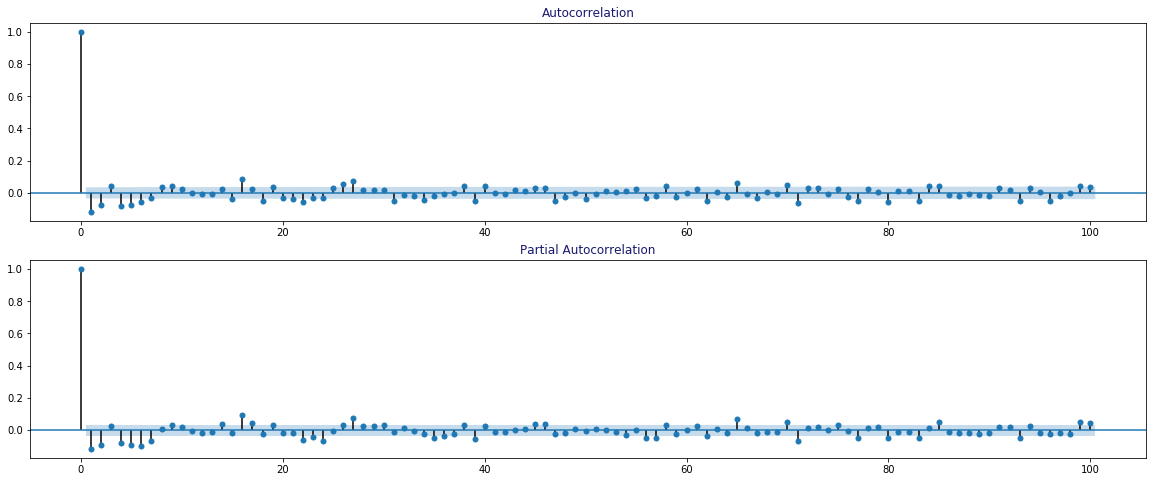

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))
plot_acf(spots.values, lags=100, ax=ax1)
plot_pacf(spots.values, lags=100, ax=ax2)
plt.show()

##### Conclusion: 
Try different values of p and q as they affect each other. 

Rule of thumb: choose lower lag first (here ACF plot - parameter q and then choose p by the PACF plot). 

q = 6 

p = 7

##### First ARIMA set up

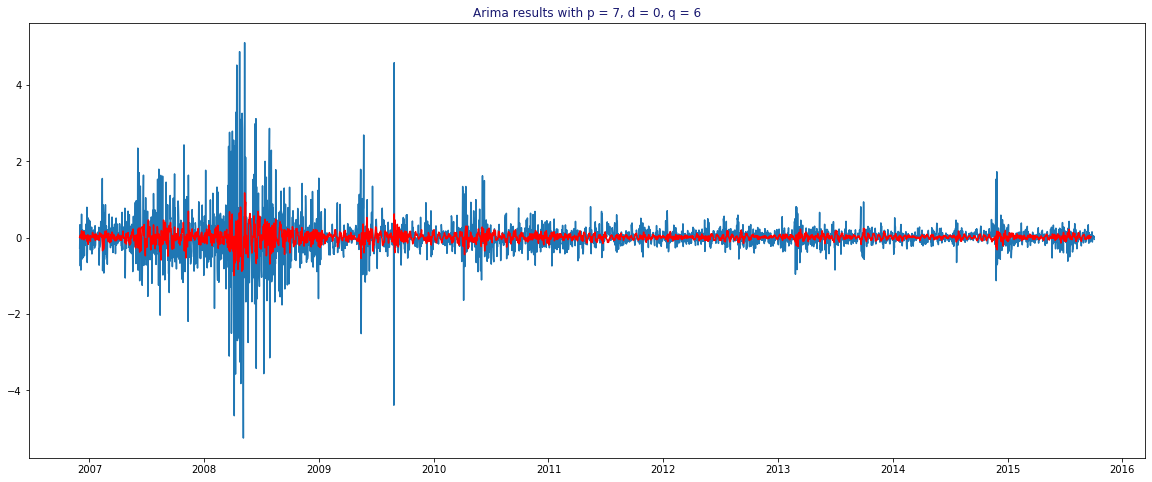

In [34]:
model = ARIMA(spots_train, order=(7, 0, 6))
result_arima_706 = model.fit()
plt.figure(figsize=(20, 8))
plt.plot(spots)
plt.title(f"Arima results with p = {str(7)}, d = {str(0)}, q = {str(6)}")
plt.plot(result_arima_705.fittedvalues, color="red")

### Conclusion: 
The model is not good enough as the lags are not high enough. It is able to pick up on increasing volatility though. To better understand the problem, let's see the model residuals. 

Ideal setup: model with zero mean and constant variance, residuals that are uncorrelated and that follow a normal distribution. 

##### Model residuals 

In [33]:
spots_train.tail()

2015-09-20   -0.118149
2015-09-21    0.081176
2015-09-22   -0.027169
2015-09-23    0.073216
2015-09-24    0.051469
Freq: D, dtype: float64

In [35]:
result_arima_706.fittedvalues.tail()

2015-09-20   -0.004335
2015-09-21    0.004626
2015-09-22   -0.007675
2015-09-23    0.014730
2015-09-24    0.027030
Freq: D, dtype: float64

In [37]:
result_arima_706.resid.tail()

2015-09-20   -0.113814
2015-09-21    0.076551
2015-09-22   -0.019494
2015-09-23    0.058486
2015-09-24    0.024439
Freq: D, dtype: float64

In [40]:
0.051469 - 0.027030

0.024439000000000002

The residual mean: -3.971870836439472e-05


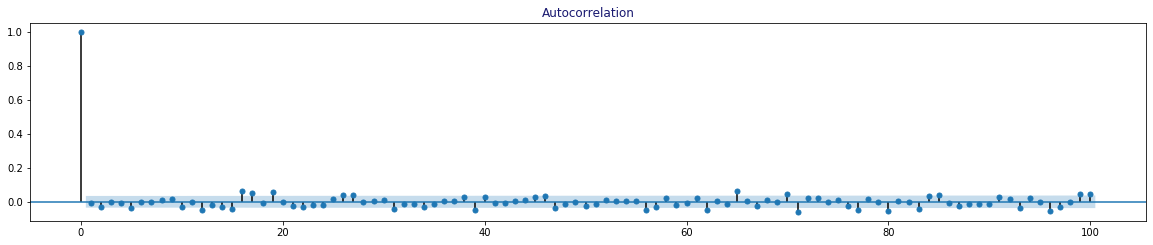

In [43]:
# We need to know the mean, correlation and distribution of the residuals. 

print(f"The residual mean: {np.mean(result_arima_705.resid)}") # Result is close to 0, it's good. 

# ACF plot for autocorrelation between the residuals 
%matplotlib inline 
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(result_arima_705.resid, lags = 100, ax = ax1)

As we have 100 lags, 5 could be outside the 95% threshold but more than that indicates model readjustment. 
(We have more than 5, adjust model parameters.)

Lastly, see distribution of the residuals: 

In [45]:
from numpy import linspace
from scipy.stats import norm 

def residual_histogram(residuals): 
    
    fig = plt.figure(figsize=(20, 8))

    plt.hist(residuals, bins="auto", density=True, rwidth=0.5, label="Residuals")
    mean_resid, std_resid = norm.fit(residuals)
    x_min, x_max = plt.xlim()
    
    curve_length = linspace(x_min, x_max, 100)
    bell_curve = norm.pdf(curve_length, mean_resid, std_resid)
    plt.plot(curve_length, bell_curve, "red", linewidth=2)
    plt.grid(axis="y", alpha=0.2)
    plt.xlabel("Residuals")
    plt.ylabel("Density")
    plt.title(f"Residuals vs Normal distribution with {round(mean_resid, 3)} mean and {round(std_resid, 3)} std")
    
    plt.show()
    
    return 

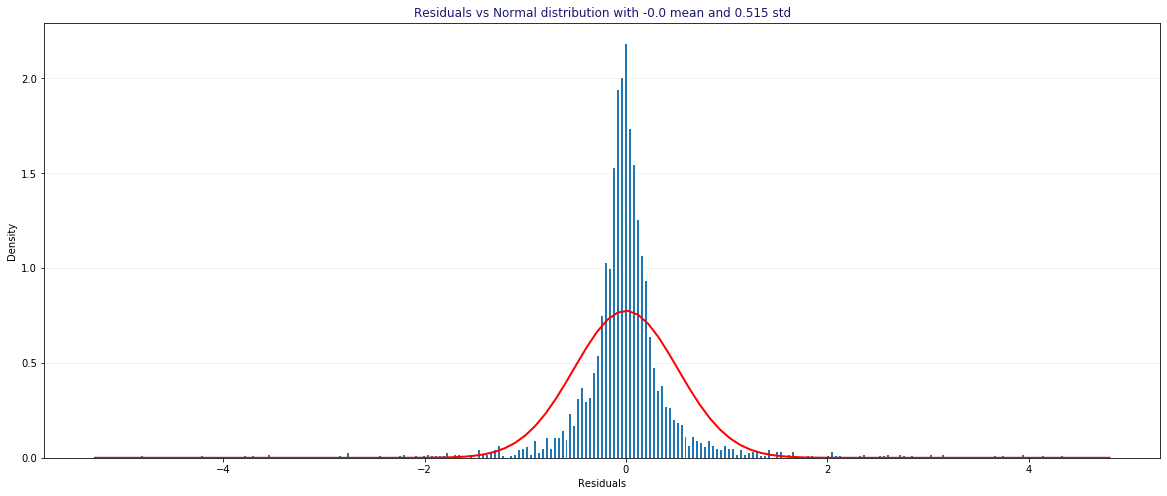

In [46]:
residual_histogram(result_arima_706.resid)

In [48]:
# Check AIC and BIC (the lower the better)

result_arima_706.summary()
# P value = the null hypothesis that the coefficient is equal to zero (no effect).
# Low p-value (< 0.05) => reject the null hypothesis.

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 3220
Model:                     ARMA(7, 6)   Log Likelihood               -2429.248
Method:                       css-mle   S.D. of innovations              0.514
Date:                Tue, 10 Mar 2020   AIC                           4888.496
Time:                        17:24:53   BIC                           4979.653
Sample:                    12-01-2006   HQIC                          4921.167
                         - 09-24-2015                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0132      0.007      1.910      0.056      -0.000       0.027
ar.L1.y        0.7888      0.077     10.301      0.000       0.639       0.939
ar.L2.y        0.5483      0.110      4.985      0.000       0.333       0.764
ar.L3.y       -1.3062      0.081    -16.114      0.000      -1.465      -1.147
ar.L4.y        0.3548      0.079      4.475      0.000       0.199       0.510
ar.L5.y        0.6259      0.093      6.711      0.000       0.443       0.809
ar.L6.y       -0.5680      0.059     -9.600      0.000      -0.684      -0.452
ar.L7.y       -0.1053      0.025     -4.140      0.000      -0.155      -0.055
ma.L1.y       -0.9365      0.075    -12.470      0.000      -1.084      -0.789
ma.L2.y       -0.4971      0.115     -4.331      0.000      -0.722      -0.272
ma.L3.y        1.4731      0.075     19.521      0.000       1.325       1.621
ma.L4.y       -0.6232      0.087     -7.165      0.000      -0.794      -0.453
ma.L5.y       -0.6589      0.097     -6.822      0.000      -0.848      -0.470
ma.L6.y        0.7464      0.055     13.668      0.000       0.639       0.853
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9540           -0.4273j            1.0454           -0.0670
AR.2            0.9540           +0.4273j            1.0454            0.0670
AR.3            0.5262           -0.9227j            1.0622           -0.1675
AR.4            0.5262           +0.9227j            1.0622            0.1675
AR.5           -1.0724           -0.3008j            1.1138           -0.4565
AR.6           -1.0724           +0.3008j            1.1138            0.4565
AR.7           -6.2103           -0.0000j            6.2103           -0.5000
MA.1           -1.0356           -0.2818j            1.0732           -0.4577
MA.2           -1.0356           +0.2818j            1.0732            0.4577
MA.3            0.5110           -0.9010j            1.0358           -0.1679
MA.4            0.5110           +0.9010j            1.0358            0.1679
MA.5            0.9660           -0.3885j            1.0412           -0.0609
MA.6            0.9660           +0.3885j            1.0412            0.0609
-----------------------------------------------------------------------------
"""

#### Forecast ARIMA 

In [50]:
spots_test

2015-09-25   -0.071540
2015-09-26    0.052775
2015-09-27    0.153400
2015-09-28   -0.114312
2015-09-29    0.029991
2015-09-30    0.022836
2015-10-01    0.053275
2015-10-02    0.006670
2015-10-03    0.037068
2015-10-04   -0.043300
Freq: D, dtype: float64

In [51]:
forecast_706 = result_arima_706.predict(start="2015-09-25", end="2015-10-04")

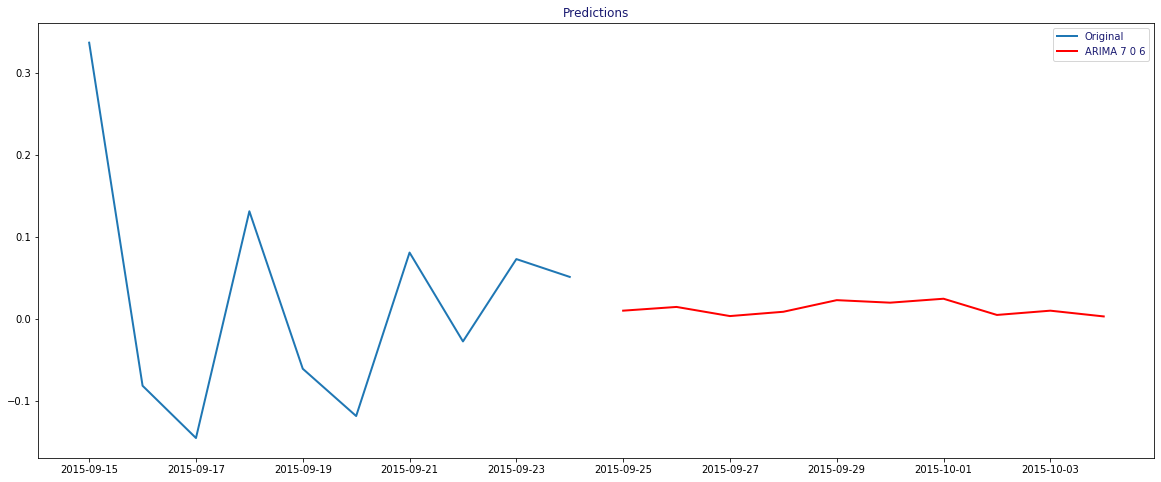

In [52]:
plt.figure(figsize=(20, 8))
plt.plot(spots_train[-10:], linewidth=2, label="Original")
plt.plot(forecast_706, color="red", linewidth=2, label="ARIMA 7 0 6")
plt.legend()
plt.title("Predictions")
plt.show()

In [55]:
model = ARIMA(spots_train, order=(7, 0, 6))
result_arima_706 = model.fit()

In [58]:
result_arima_706.aic

4888.49584448468

In [64]:
result_arima_706.conf_int()

,0,1
const,-0.000342,0.026724
ar.L1.y,0.638740,0.938930
ar.L2.y,0.332718,0.763907
ar.L3.y,-1.465113,-1.147354
ar.L4.y,0.199399,0.510232
ar.L5.y,0.443096,0.808701
ar.L6.y,-0.683924,-0.452003
ar.L7.y,-0.155120,-0.055444
ma.L1.y,-1.083655,-0.789287
ma.L2.y,-0.722018,-0.272100


# AR model 

###### High lag AR model

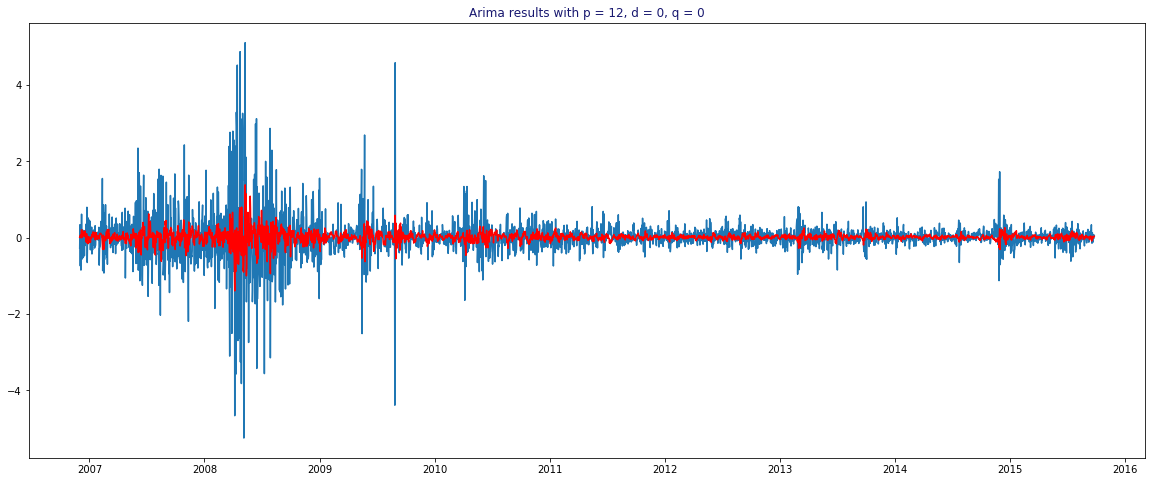

In [76]:
model_12_0_0 = ARIMA(spots_train, order=(20, 0, 0))
result_arima_20_0_0 = model_12_0_0.fit()

plt.figure(figsize=(20, 8))
plt.plot(spots_train)
plt.title(f"Arima results with p = {str(12)}, d = {str(0)}, q = {str(0)}")
plt.plot(result_arima_20_0_0.fittedvalues, color="red")

The residual mean: 1.8443127583467265e-05


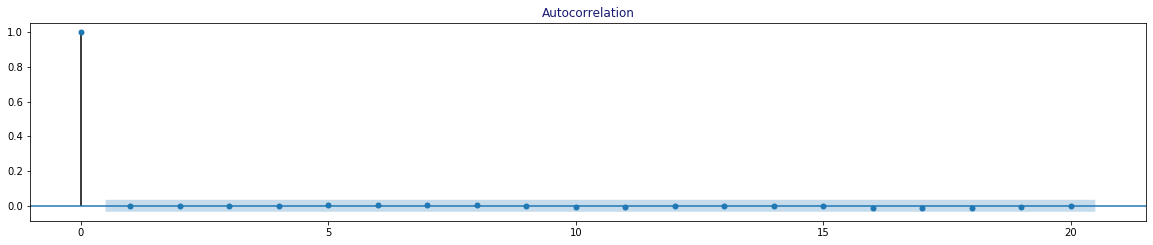

In [78]:
from src.ts_test import plot_acf_residuals

plot_acf_residuals(result_arima_20_0_0.resid, 20)

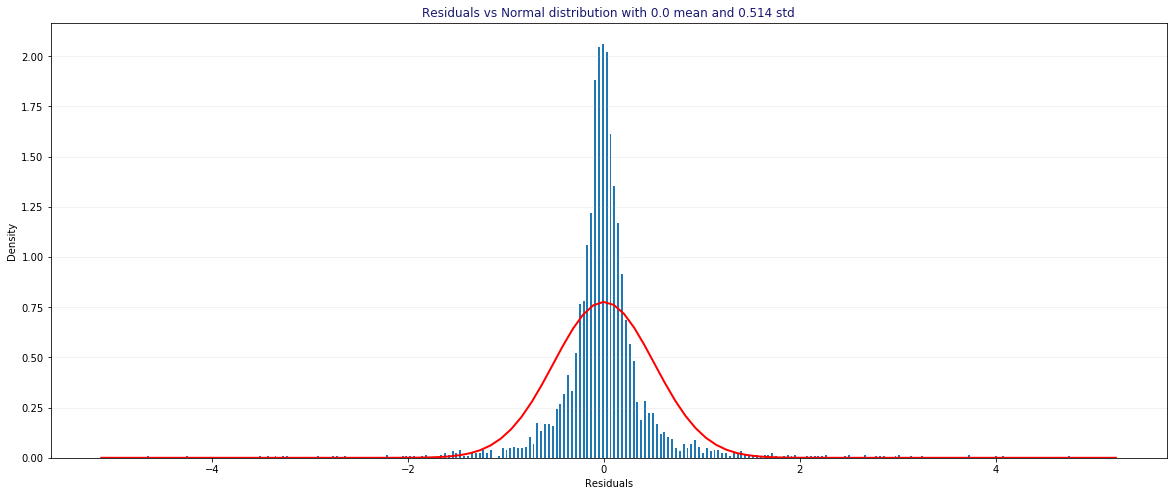

In [81]:
from src.ts_test import residual_histogram

residual_histogram(result_arima_20_0_0.resid)

In [83]:
result_arima_20_0_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 3220
Model:                    ARMA(20, 0)   Log Likelihood               -2424.245
Method:                       css-mle   S.D. of innovations              0.514
Date:                Tue, 10 Mar 2020   AIC                           4892.490
Time:                        18:33:56   BIC                           5026.187
Sample:                    12-01-2006   HQIC                          4940.407
                         - 09-24-2015                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0132      0.007      2.006      0.045       0.000       0.026
ar.L1.y       -0.1449      0.018     -8.222      0.000      -0.179      -0.110
ar.L2.y       -0.1096      0.018     -6.161      0.000      -0.145      -0.075
ar.L3.y        0.0019      0.018      0.104      0.918      -0.033       0.037
ar.L4.y       -0.0903      0.018     -5.051      0.000      -0.125      -0.055
ar.L5.y       -0.1066      0.018     -5.962      0.000      -0.142      -0.072
ar.L6.y       -0.1068      0.018     -5.937      0.000      -0.142      -0.072
ar.L7.y       -0.0654      0.018     -3.620      0.000      -0.101      -0.030
ar.L8.y        0.0123      0.018      0.677      0.498      -0.023       0.048
ar.L9.y        0.0378      0.018      2.088      0.037       0.002       0.073
ar.L10.y       0.0288      0.018      1.590      0.112      -0.007       0.064
ar.L11.y      -0.0007      0.018     -0.036      0.971      -0.036       0.035
ar.L12.y      -0.0012      0.018     -0.069      0.945      -0.037       0.034
ar.L13.y      -0.0036      0.018     -0.201      0.841      -0.039       0.032
ar.L14.y       0.0414      0.018      2.291      0.022       0.006       0.077
ar.L15.y      -0.0009      0.018     -0.052      0.959      -0.036       0.034
ar.L16.y       0.0940      0.018      5.260      0.000       0.059       0.129
ar.L17.y       0.0427      0.018      2.387      0.017       0.008       0.078
ar.L18.y      -0.0195      0.018     -1.090      0.276      -0.055       0.016
ar.L19.y       0.0261      0.018      1.469      0.142      -0.009       0.061
ar.L20.y      -0.0151      0.018     -0.859      0.390      -0.050       0.019
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0016           -0.5139j            1.1257           -0.4246
AR.2            -1.0016           +0.5139j            1.1257            0.4246
AR.3            -1.1893           -0.1455j            1.1982           -0.4806
AR.4            -1.1893           +0.1455j            1.1982            0.4806
AR.5            -0.7432           -0.8222j            1.1084           -0.3670
AR.6            -0.7432           +0.8222j            1.1084            0.3670
AR.7            -0.4193           -1.0517j            1.1322           -0.3104
AR.8            -0.4193           +1.0517j            1.1322            0.3104
AR.9             0.0036           -1.1770j            1.1770           -0.2495
AR.10            0.0036           +1.1770j            1.1770            0.2495
AR.11            0.4428           -1.1225j            1.2067           -0.1902
AR.12            0.4428           +1.1225j            1.2067            0.1902
AR.13            0.2110           -1.6197j            1.6333           -0.2294
AR

In [84]:
forecast_20_0_0 = result_arima_20_0_0.predict(start="2015-09-25", end="2015-10-04")

# Moving average model 

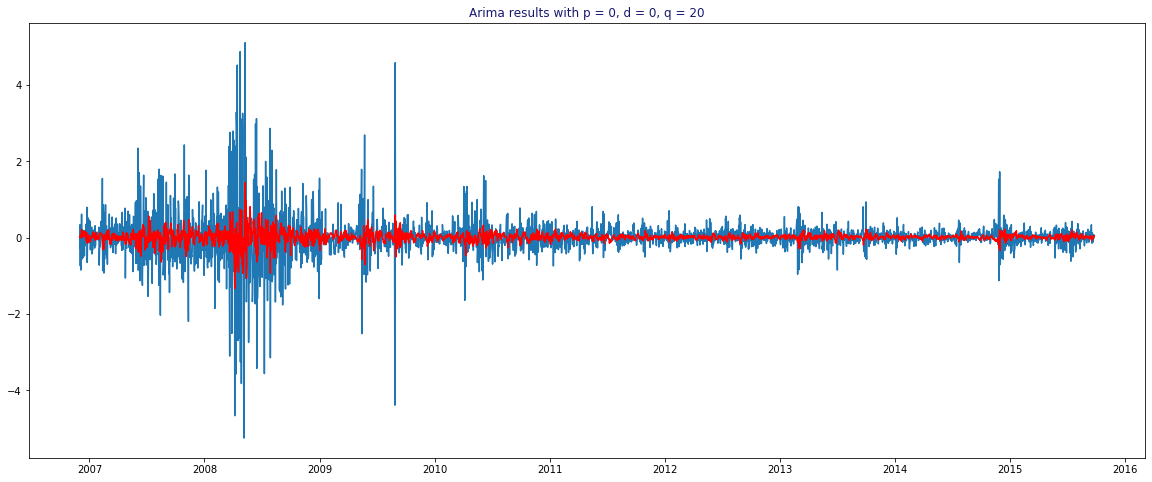

In [90]:
model_0_0_20 = ARIMA(spots_train, order=(0, 0, 20))
result_arima_0_0_20 = model_0_0_10.fit()

plt.figure(figsize=(20, 8))
plt.plot(spots_train)
plt.title(f"Arima results with p = {str(0)}, d = {str(0)}, q = {str(20)}")
plt.plot(result_arima_0_0_20.fittedvalues, color="red")

In [93]:
result_arima_0_0_20.aic

4897.96720921106

In [94]:
forecast_0_0_20 = result_arima_0_0_20.predict(start="2015-09-25", end="2015-10-04")

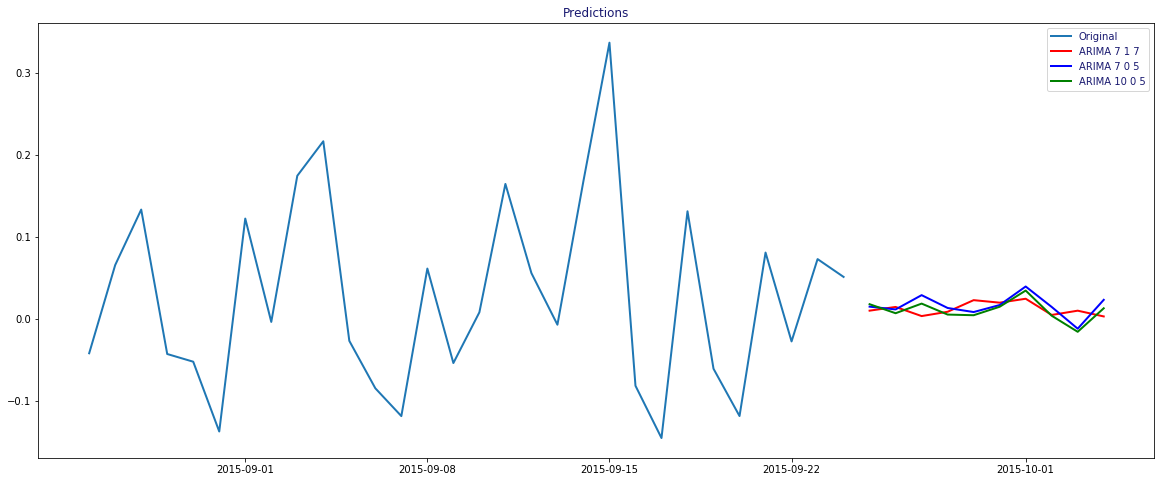

In [99]:
plt.figure(figsize=(20, 8))
plt.plot(spots_train[-30:], linewidth=2, label="Original")
plt.plot(forecast_706, color="red", linewidth=2, label="ARIMA 7 1 7")
plt.plot(forecast_20_0_0, color="blue", linewidth=2, label="ARIMA 7 0 5")
plt.plot(forecast_0_0_20, color="green", linewidth=2, label="ARIMA 10 0 5")
plt.legend()
plt.title("Predictions")
plt.show()

# Seasonal Arima Model 

Seasonal Autoregressive Integrated Moving Average, SARIMA

ARIMA(p, d, q)[P, D, Q][freq]

Second part is the seasonal part.

In [103]:
# Package is still in development process 
import pmdarima as pm

pm.auto_arima

<function pmdarima.arima.auto.auto_arima(y, exogenous=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=False, error_action='warn', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept=True, sarimax_kwargs=None, **fit_args)>

In [107]:
spots_train_sarima = spots_train[-100:]
spots_train_sarima

2015-06-17   -0.381292
2015-06-18    0.204590
2015-06-19    0.216497
2015-06-20   -0.133607
2015-06-21    0.000000
                ...   
2015-09-20   -0.118149
2015-09-21    0.081176
2015-09-22   -0.027169
2015-09-23    0.073216
2015-09-24    0.051469
Freq: D, Length: 100, dtype: float64

In [109]:
sarima = pm.auto_arima(spots_train_sarima, error_action="ignore", suppress_warnings=True, seasonal=True, m=31, \
                      d=0, start_q=1, start_p=1, start_Q=0, start_P=0, max_order=3, max_d=0, max_D=1, D=1, stepwise=True, trace=True)

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 1, 0, 31) (constant=True); AIC=13.887, BIC=22.823, Time=0.717 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 31) (constant=True); AIC=10.480, BIC=14.948, Time=0.069 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 31) (constant=True); AIC=4.707, BIC=13.644, Time=3.634 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 31) (constant=True); AIC=5.844, BIC=14.780, Time=1.400 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 31) (constant=False); AIC=8.653, BIC=10.887, Time=0.047 seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 0, 31) (constant=True); AIC=12.426, BIC=19.128, Time=0.291 seconds
Fit ARIMA: (1, 0, 0)x(2, 1, 0, 31) (constant=True); AIC=1.494, BIC=12.665, Time=9.722 seconds
Near non-invertible roots for order (1, 0, 0)(2, 1, 0, 31); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (1, 0, 0)x(1, 1, 1, 31) (constant=True); AIC=5.049, BIC=16.220, Time=5.612 seconds
Near non-invertible roots for order (1, 0,

In [110]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  100
Model:             SARIMAX(2, 1, 0, 31)   Log Likelihood                   3.861
Date:                  Wed, 11 Mar 2020   AIC                              0.279
Time:                          09:15:32   BIC                              9.215
Sample:                               0   HQIC                             3.824
                                  - 100                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0036      0.009      0.419      0.675      -0.013       0.020
ar.S.L31      -0.0733      0.099     -0.739      0.460      -0.268       0.121
ar.S.L62       0.8202      0.228      3.594      0.000       0.373       1.268
sigma2         0.0177      0.020      0.885      0.376      -0.021       0.057
===================================================================================
Ljung-Box (Q):                       38.45   Jarque-Bera (JB):                 2.70
Prob(Q):                              0.54   Prob(JB):                         0.26
Heteroskedasticity (H):               0.72   Skew:                             0.32
Prob(H) (two-sided):                  0.43   Kurtosis:                         2.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [113]:
len(spots_test)

10

In [131]:
forecasts_sarima = sarima.predict(spots_test.shape[0])  # predict 10 steps into the future
forecasts_sarima

forecasts_sarima = pd.Series(forecasts_sarima, index=pd.date_range(start="2015-09-24", periods=10, end="2015-10-04"))

In [132]:
forecasts_sarima

2015-09-24 00:00:00   -0.342354
2015-09-25 02:40:00   -0.316170
2015-09-26 05:20:00   -0.246735
2015-09-27 08:00:00   -0.097700
2015-09-28 10:40:00    0.033203
2015-09-29 13:20:00   -0.289963
2015-09-30 16:00:00    0.075352
2015-10-01 18:40:00    0.042456
2015-10-02 21:20:00   -0.154384
2015-10-04 00:00:00    0.502469
dtype: float64

In [121]:
spots_train_sarima

2015-06-17   -0.381292
2015-06-18    0.204590
2015-06-19    0.216497
2015-06-20   -0.133607
2015-06-21    0.000000
                ...   
2015-09-20   -0.118149
2015-09-21    0.081176
2015-09-22   -0.027169
2015-09-23    0.073216
2015-09-24    0.051469
Freq: D, Length: 100, dtype: float64

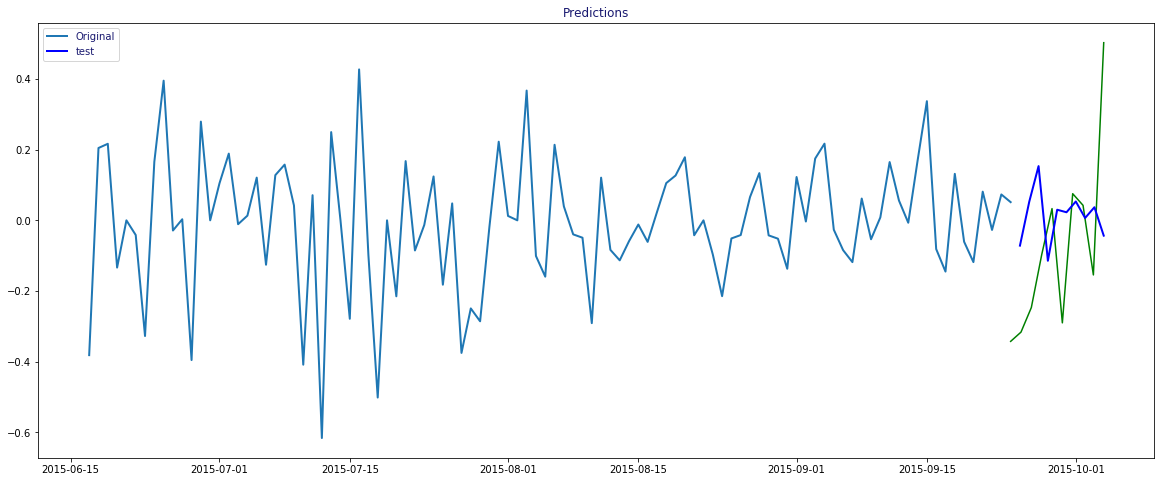

In [134]:
plt.figure(figsize=(20, 8))
x = np.arange(spots_train_sarima.shape[0]+10)
plt.plot(spots_train_sarima, linewidth=2, label="Original")
plt.plot(forecasts_sarima, c='green')
plt.plot(spots_test, color="blue", linewidth=2, label="test")
plt.legend()
plt.title("Predictions")
plt.show()

# Exponential smoothing 

Idea: describe the TS with the initial level (error), the trend and the seasonality. The first can be additive or multiplicative, the second and third additive, multiplicative or non-present. If negative values are observed, multiplicative models are less good. With exponential smoothing, put more weights on recent observations and less on past values. 

Smoothing coefficient: in [0, 1]. If close to 0, very smooth model (goes back in time a lot) if around 1, very reactive model.

Initial trend: alpha 
Trend: Beta 
Gamma: Seasonality (non-present) 
Phi: Damping parameter (Idea: trend must be present but not constant forever. -> Parameter phi decides the level of trend damping). If Phi around 0, we have a flattened curve (the trend gets smooth) and if phi around 1, we have a constant trend model. In practice, 0.8 < phi < 0.98. 



In [147]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

In [174]:
model_fit_1 = SimpleExpSmoothing(spots_train).fit(smoothing_level=0.9)
forecast_1  = model_fit_1.forecast(10)

model_fit_2 = SimpleExpSmoothing(spots_train).fit(smoothing_level=0.2)
forecast_2  = model_fit_2.forecast(10)

model_fit_3 = SimpleExpSmoothing(spots_train).fit(smoothing_level=0.7)
forecast_3  = model_fit_3.forecast(10)

print(forecast_1, forecast_2, forecast_3, spots_test)

2015-09-25    0.052729
2015-09-26    0.052729
2015-09-27    0.052729
2015-09-28    0.052729
2015-09-29    0.052729
2015-09-30    0.052729
2015-10-01    0.052729
2015-10-02    0.052729
2015-10-03    0.052729
2015-10-04    0.052729
Freq: D, dtype: float64 2015-09-25    0.026344
2015-09-26    0.026344
2015-09-27    0.026344
2015-09-28    0.026344
2015-09-29    0.026344
2015-09-30    0.026344
2015-10-01    0.026344
2015-10-02    0.026344
2015-10-03    0.026344
2015-10-04    0.026344
Freq: D, dtype: float64 2015-09-25    0.0505
2015-09-26    0.0505
2015-09-27    0.0505
2015-09-28    0.0505
2015-09-29    0.0505
2015-09-30    0.0505
2015-10-01    0.0505
2015-10-02    0.0505
2015-10-03    0.0505
2015-10-04    0.0505
Freq: D, dtype: float64 2015-09-25   -0.071540
2015-09-26    0.052775
2015-09-27    0.153400
2015-09-28   -0.114312
2015-09-29    0.029991
2015-09-30    0.022836
2015-10-01    0.053275
2015-10-02    0.006670
2015-10-03    0.037068
2015-10-04   -0.043300
Freq: D, dtype: float64


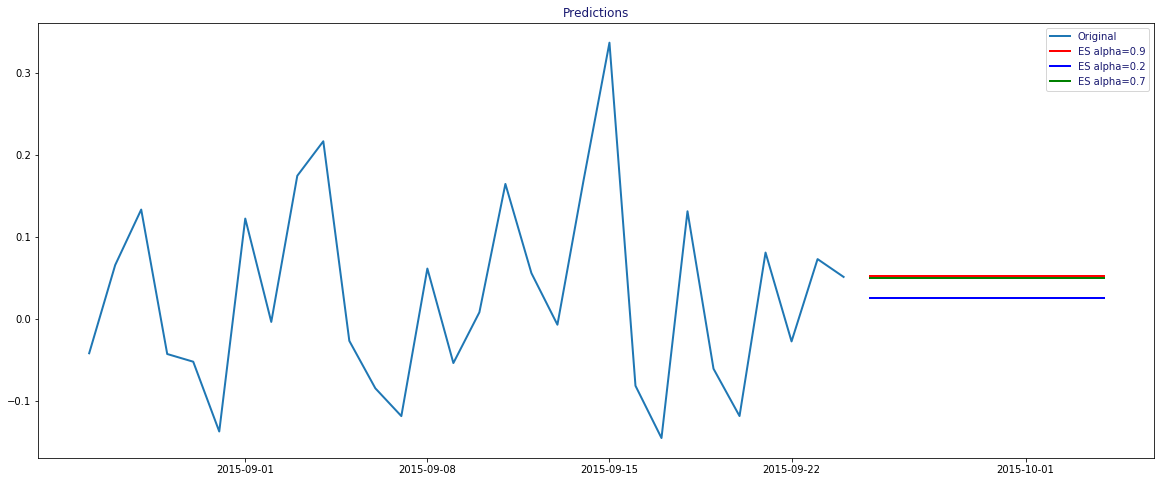

In [172]:
plt.figure(figsize=(20, 8))
plt.plot(spots_train[-30:], linewidth=2, label="Original")
plt.plot(forecast_1, color="red", linewidth=2, label="ES alpha=0.9")
plt.plot(forecast_2, color="blue", linewidth=2, label="ES alpha=0.2")
plt.plot(forecast_3, color="green", linewidth=2, label="ES alpha=0.7")
plt.legend()
plt.title("Predictions")
plt.show()

In [186]:
expsmodel = ExponentialSmoothing(spots_train, seasonal=None)
# Fitting the model 
expsmodel_fit = expsmodel.fit(smoothing_level=0.3)

In [187]:
expsmodel_fit.params

{'smoothing_level': 0.3,
 'smoothing_slope': nan,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 0.0,
 'initial_slope': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [188]:
expsforecast = expsmodel_fit.forecast(10)
expsforecast

2015-09-25    0.029401
2015-09-26    0.029401
2015-09-27    0.029401
2015-09-28    0.029401
2015-09-29    0.029401
2015-09-30    0.029401
2015-10-01    0.029401
2015-10-02    0.029401
2015-10-03    0.029401
2015-10-04    0.029401
Freq: D, dtype: float64

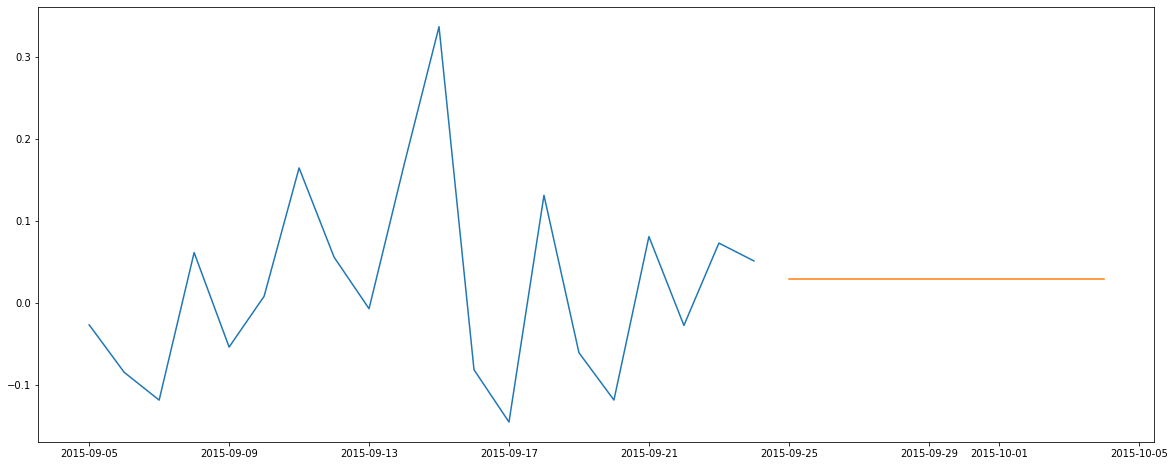

In [191]:
plt.figure(figsize=(20, 8))
plt.plot(spots_train[-20:], label="Original")
plt.plot(expsforecast, label="alpha=0.3")


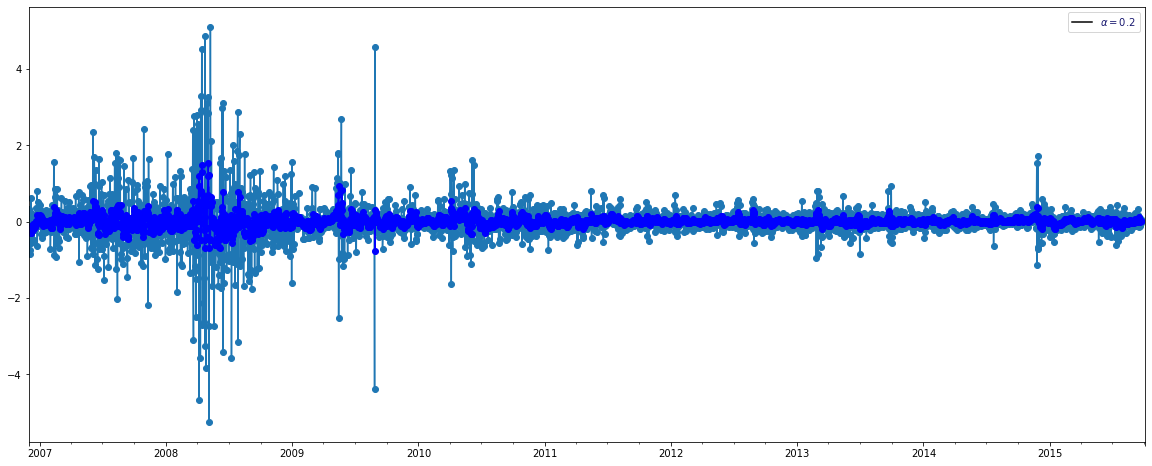

In [158]:
fit1 = SimpleExpSmoothing(spots_train).fit(smoothing_level=0.2,optimized=False)
fcast1 = fit1.forecast(10).rename(r'$\alpha=0.2$')

fit2 = SimpleExpSmoothing(spots_train).fit(smoothing_level=0.6,optimized=False)
fcast2 = fit2.forecast(10).rename(r'$\alpha=0.6$')
fit3 = SimpleExpSmoothing(spots_train).fit()
fcast3 = fit3.forecast(10).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])

ax = spots_train.plot(marker='o', figsize=(20,8))
fcast1.plot(ax=ax, color='black', legend=True)
fit1.fittedvalues.plot(marker='o', ax=ax, color='blue')
#fcast2.plot(marker='o', ax=ax, color='red', legend=True)

#fit2.fittedvalues.plot(marker='o', ax=ax, color='red')
#fcast3.plot(marker='o', ax=ax, color='green', legend=True)
#fit3.fittedvalues.plot(marker='o', ax=ax, color='green')
plt.show()